In [1]:
import os
import cv2
import numpy as np
import torch
import dlib
from imutils import face_utils
from basicsr.archs.rrdbnet_arch import RRDBNet
from basicsr.utils.download_util import load_file_from_url
from torchvision import transforms  
import torch.nn as nn
from torch.utils.data import Dataset
from albumentations.pytorch import ToTensorV2
import albumentations as A
import torch.nn.functional as F
import math
import time
from imutils import face_utils
from scipy.spatial import distance as dist
import matplotlib.pyplot as plt
import mediapipe
from BaseModels.resnetModels import BB_model
from BaseModels.efficientnetModels import BB_model
import pandas as pd
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from scipy.spatial import distance
import sys
sys.path.append("../LuminEye-MainPipeLine/")
# device = "cpu"


    


In [2]:
# # Load Model 256
model_U = torch.load(
    "/home/nipun/Documents/Uni_Malta/LuminEye/LuminEye-Experiments/U2net/U2NET_MULTICLASS_IMG_256_DIC_batch_8/Miche_model_2023_04_11_22:14:26_val_iou0.900.pt", map_location=device)


model_U.eval()

RESIZE_AMT = 256

In [3]:
# MP2GAZE
val_csv_path = "/home/nipun/Documents/Uni_Malta/Datasets/CenterRegression/MP2GAZE/AllCoordinatesMp2GazeTest.csv"


val_df = pd.read_csv(val_csv_path)



In [4]:
val_df.head()

,ImageName,Coordinates,DataSet Type
0,"MPIIGaze/Data/Original/p00/day02/0350.jpg""","[576.75131084363, 446.9430824441167, 595.62107...",MP2GAZE
1,"MPIIGaze/Data/Original/p00/day23/0201.jpg""","[629.1027244977723, 418.5422721626321, 649.159...",MP2GAZE
2,"MPIIGaze/Data/Original/p00/day22/0437.jpg""","[519.3837103984533, 379.3424773235636, 551.963...",MP2GAZE
3,"MPIIGaze/Data/Original/p00/day34/0296.jpg""","[563.4499942709884, 374.6517620194357, 591.877...",MP2GAZE
4,"MPIIGaze/Data/Original/p00/day10/0198.jpg""","[659.4630047049818, 463.58724173032533, 685.19...",MP2GAZE


In [5]:
def selectImgDir(datasetType:str):
    
    
    
    
    
    if datasetType == "MP2GAZE":
        return "/home/nipun/Documents/Uni_Malta/Datasets/"
        
        
        
    elif datasetType =="i2head":
        return "/home/nipun/Documents/Uni_Malta/Datasets/"
        
    elif datasetType == "GI4E":
        
        return "/home/nipun/Documents/Uni_Malta/Datasets/gi4e_database/images/"
        
        
        
        
    
    
    

In [6]:
def predict_image_masku2net(model, image):

    image = imgTransform(image[:, :, ::-1])

    image = image.to(device)

    with torch.no_grad():

        softmax = nn.Softmax(dim=1)
        image = image.unsqueeze(0)

        model_output, _, _, _, _, _, _ = model(image)

        output = softmax(model_output)

        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked

In [7]:
def decode_segmap(temp, n_classes=3):

    colors = [[0,   0,   0], [0, 255, 0], [0, 0, 255]]
    label_colours = dict(zip(range(n_classes), colors))
    # convert gray scale to color
    temp = temp.numpy()
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()
    for l in range(n_classes):
        r[temp == l] = label_colours[l][0]
        g[temp == l] = label_colours[l][1]
        b[temp == l] = label_colours[l][2]

    rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
    rgb[:, :, 0] = r / 255.0
    rgb[:, :, 1] = g / 255.0
    rgb[:, :, 2] = b / 255.0
    return rgb

In [8]:
def imageCenterFromConnectedComponent(img, connectivity=4):

    pred_image = decode_segmap(img) * 255

    grayscale_mask = np.argmax(pred_image, axis=-1).astype(np.uint8)

    analysis = cv2.connectedComponentsWithStats(grayscale_mask,
                                                connectivity,
                                                cv2.CV_32S)
    (totalLabels, label_ids, values, centroid) = analysis

    return centroid

In [9]:
def imgTransform(image):
    """ Transform numpy images to Torch tensors

    Args:
        image (_numpy_): _cropped_eye_region_
        resize_amt (_int_): _Input Resize for the image_

    Returns:
        _torch.float32_: _Transformed image tensor_
    """

    transform = A.Compose([
        A.Resize(RESIZE_AMT, RESIZE_AMT),
        A.augmentations.transforms.Normalize(
            mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
        ToTensorV2()
    ])

    return transform(image=image)["image"]

In [10]:
def cropeyes(image, inner_array, outer_array):

    arr = {"top_left": [inner_array[0]-5, inner_array[1]-20],
           "bottom_right": [outer_array[0]+5, outer_array[1]+20]}

    return image[arr["top_left"][1]:arr["bottom_right"][1], arr["top_left"][0]:arr["bottom_right"][0]], arr

In [11]:



def rescale_coordinate(coord,original_image,resize_amt):
    
    h,w = original_image.shape[:2]
    coord[0] = int((coord[0]/resize_amt) * w)
    coord[1] = int((coord[1]/resize_amt) * h)
    
    return coord

In [12]:
def scaleCoorinatesToOriginalImage(pred_coords,eye_margin):
    
    # {'top_left': array([385, 214]), 'bottom_right': array([426, 226])}
    
    x1 = eye_margin["top_left"][0] + pred_coords[0]
    y1 = eye_margin["top_left"][1] + pred_coords[1]
    
    return [x1,y1]
    

In [13]:
def calculateEuclideanDistance(coord1,coord2):
    return (((coord1[0])-float(coord2[0]))^2  + (float(coord1[0])-float(coord2[0]))^2) ^ 0.5

In [14]:
IMG_DIR = "/home/nipun/Documents/Uni_Malta/Datasets/"

In [15]:
maximizedNormalizedError = []

count = 0
for i, (_, rows) in enumerate(val_df.iterrows()):

        bbox = [int(float(x)) for x in rows["Coordinates"][1:-1].split(',')]

        left_inner = bbox[0:2]
        left_center = bbox[2:4]
        left_outer = bbox[4:6]

        right_inner = bbox[6:8]
        right_center = bbox[8:10]
        right_outer = bbox[10:12]

        img_path = os.path.join(IMG_DIR, rows["ImageName"][:-1])
        # #
        img = cv2.imread(img_path)


        IPD = distance.euclidean(left_center, right_center)
        

       

        left_eye, Leye = cropeyes(img, left_inner, left_outer)
        right_eye, Reye = cropeyes(img, right_inner, right_outer)
        
        
        pred_l_eye, pred_r_eye = predict_image_masku2net(
            model_U, left_eye), predict_image_masku2net(model_U, right_eye)
        
        
        left_centroid = imageCenterFromConnectedComponent(pred_l_eye)[-1]
        right_centroid = imageCenterFromConnectedComponent(pred_r_eye)[-1]
        
        
        
        
        

        pred_l_eye_center = rescale_coordinate(left_centroid, left_eye, RESIZE_AMT)

        pred_r_eye_center = rescale_coordinate(right_centroid, right_eye, RESIZE_AMT)

        
        
        
        
        
        
        
        
        # cv2.circle(left_eye, (int(pred_l_eye_center[0]), int(
        #     pred_l_eye_center[1])), 1, (0, 255, 0), -1)

        # cv2.circle(right_eye, (int(pred_r_eye_center[0]), int(
        #     pred_r_eye_center[1])), 1, (0, 255, 0), -1)
        

        # fig, axes = plt.subplots(2, 2)

        # fig.set_figheight(8)
        # fig.set_figwidth(8)

        # axes[0][0].imshow(left_eye)
        # axes[0][1].imshow(pred_l_eye)

        # axes[1][0].imshow(right_eye)
        # axes[1][1].imshow(pred_r_eye)

        count += 1
        

        
        pred_l_eye_toOriginaImage = scaleCoorinatesToOriginalImage(
            pred_l_eye_center, Leye)
        pred_r_eye_toOriginaImage = scaleCoorinatesToOriginalImage(
            pred_r_eye_center, Reye)
        
        

        # # print(pred_l_eye_toOriginaImage)
        # # print(coords[2:4])

        cv2.circle(img, (int(pred_l_eye_toOriginaImage[0]), int(
            pred_l_eye_toOriginaImage[1])), 1, (0, 255, 0), -1)

        cv2.circle(img, (int(pred_r_eye_toOriginaImage[0]), int(
            pred_r_eye_toOriginaImage[1])), 1, (0, 255, 0), -1)
        
        
        
        cv2.circle(img, (int(left_center[0]), int(
            left_center[1])), 1, (0, 0, 255), -1)

        cv2.circle(img, (int(right_center[0]), int(
            right_center[1])), 1, (0, 0, 255), -1)
        
        
        # plt.figure(figsize=(10,10))
        # plt.imshow(img[:,:,::-1])
        # plt.show()

        left_eye_euclidea_distance = distance.euclidean(
            pred_l_eye_toOriginaImage, left_center)

        right_eye_euclidea_distance = distance.euclidean(
            pred_r_eye_toOriginaImage, right_center)

        eMax = max(left_eye_euclidea_distance, right_eye_euclidea_distance)/IPD

        print(eMax)

        maximizedNormalizedError.append(eMax)
        # break
        # if count ==10:
        #     break

/home/nipun/.local/lib/python3.10/site-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


0.0075179470267321075
0.0
0.006321016541654178
0.0072461865655470544
0.011036425130401262
0.006991468622042873
0.0055828472590842525
0.011528191356837568
0.005772540681943417
0.018789823781967165
0.014474144679084316
0.014492753623188406
0.006112464870141717
0.01845917933256439
0.02194122358732865
0.014468462378586958
0.008996058340958934
0.014596984793312546
0.018362925952195547
0.034816772452925485
0.009233567043002652
0.011145218132094787
0.01642569885854426
0.008894249014548118
0.007461855486748755
0.01817280910462035
0.017991752671666816
0.009037292514618133
0.02343312028655591
0.009820690716414294
0.011974115989261225
0.010712509552549888
0.009998700253445089
0.012623284572736844
0.007770286898858114
0.01208244186660354
0.00752390284808123
0.011807272449596909
0.009686167061350202
0.016685216106649997
0.013153113483567893
0.018773922658852197
0.015037168948034583
0.008770580193070292
0.010959932487023821
0.011497671238805652
0.01552824984374854
0.018469811292500967
0.020995712063

In [16]:
def CheckForLess(list1, val):
    
    l1 = []
    for x in list1:
        
        if x <= val:
            l1.append(x)
    return l1

In [17]:
e_0_25 = CheckForLess(maximizedNormalizedError,0.25)

e_0_05 = CheckForLess(maximizedNormalizedError,0.05)

e_0_1 = CheckForLess(maximizedNormalizedError,0.1)

In [18]:
(len(e_0_25)/len(maximizedNormalizedError)) *100

100.0

In [19]:
(len(e_0_05)/len(maximizedNormalizedError)) * 100

97.65625

In [20]:
len(e_0_1)/len((maximizedNormalizedError)) * 100

99.21875

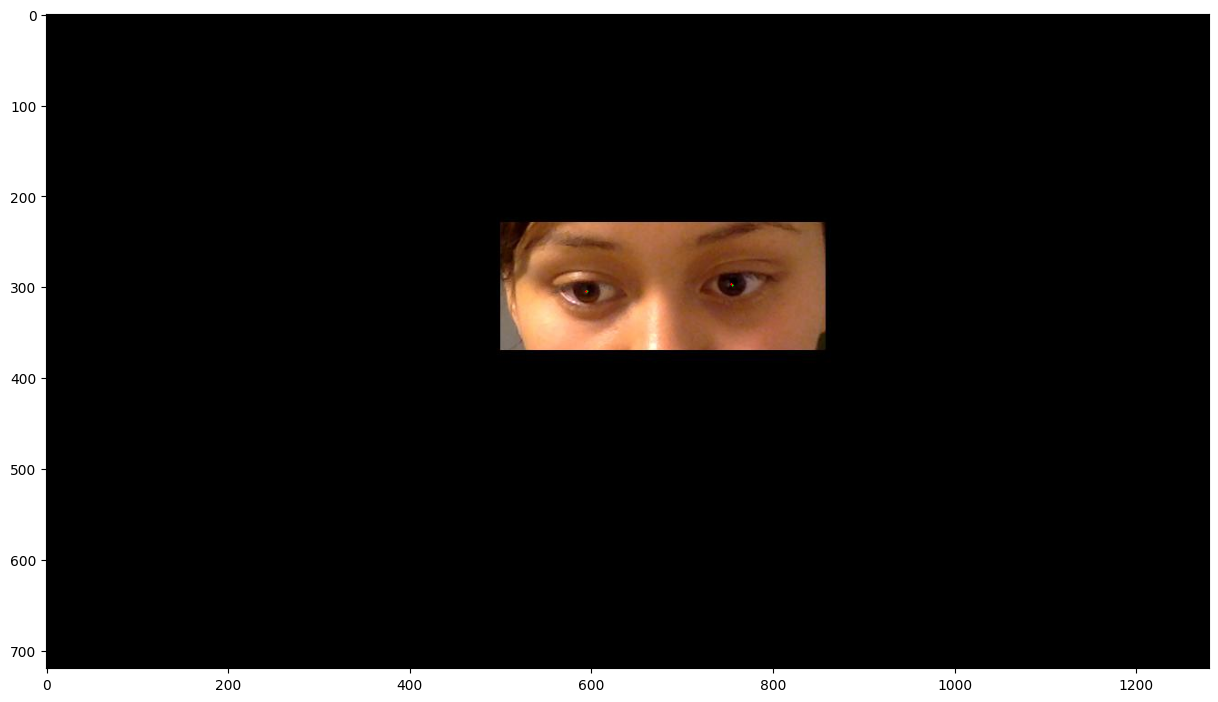

In [21]:
plt.figure(figsize=(15,15))
plt.imshow(img[:,:,::-1])


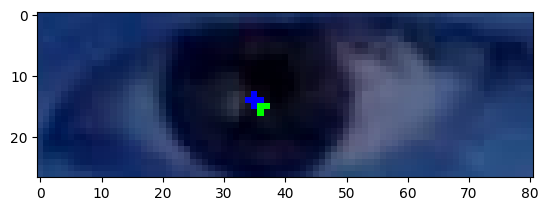

In [22]:
plt.imshow(right_eye)

In [ ]:
img_path =  "/home/nipun/Documents/Uni_Malta/Datasets/columbia_gaze_data_set/Columbia Gaze Data Set/0039/0039_2m_0P_10V_5H.jpg"

frame = cv2.imread(img_path)

plt.imshow(frame[:,:,::-1])

In [ ]:
  # MediaPipe
shape_array = captureFaceLandmarks(frame)
        

In [ ]:
left_eye, right_eye,Leye,Reye = cropped_image(frame, shape_array)
        

In [ ]:
plt.imshow(left_eye[:,:,::-1])

In [ ]:
plt.imshow(right_eye[:,:,::-1])

In [ ]:
# left = "/home/nipun/Documents/Uni_Malta/Datasets/Center_Regression/MP2GAZE/Images/417_left.png"

# left_eye = cv2.imread(left)

In [ ]:
_,pred_l_eye = prediction_image(model=REGRESSION_MODEL,image=left_eye)
        
        
_,pred_r_eye = prediction_image(model=REGRESSION_MODEL,image=right_eye)


pred_l_eye = rescale_coordinate(pred_l_eye,left_eye,RESIZE_AMT)

pred_r_eye = rescale_coordinate(pred_r_eye,right_eye,RESIZE_AMT)

In [ ]:
cv2.circle(left_eye,(int(pred_l_eye[0]),int(pred_l_eye[1])),1,(0,255,0),-1)
cv2.circle(right_eye,(int(pred_r_eye[0]),int(pred_r_eye[1])),1,(0,255,0),-1)

In [ ]:
plt.imshow(left_eye[:,:,::-1])

In [ ]:
plt.imshow(right_eye[:,:,::-1])
    

# CoordConv

In [ ]:
import numpy as np


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

plt.ion()
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

In [ ]:
def generate_data():
    # generate all of the input images
    n_samples = 56 ** 2
    onehots = np.pad(np.eye(n_samples).reshape((n_samples, 1, 56, 56)), ((0,0), (0, 0), (4,4), (4,4)), "constant")
    onehots = torch.from_numpy(onehots).float()
    with torch.no_grad():
        conv = nn.Conv2d(1, 1, kernel_size=9, padding=4, stride=1)
        conv.weight.data.fill_(1)
        conv.bias.data.fill_(0)
        dataset_x = conv(onehots)
    y_i = torch.arange(56).view(56, 1).repeat(1, 56).view(-1, 1)
    y_j = torch.arange(56).repeat(56, 1).view(-1, 1)
    dataset_y = torch.cat((y_i, y_j), dim=1)

    # split the dataset tensor into train, test sets
    sample_order = np.arange(n_samples)
    
    np.random.shuffle(sample_order)
    train_idxes = sample_order[:2352]
    test_idxes = sample_order[2352:]

    train_x = dataset_x[train_idxes]
    train_y = dataset_y[train_idxes] 
    test_x = dataset_x[test_idxes]
    test_y = dataset_y[test_idxes]

    return train_x, train_y, test_x, test_y

In [ ]:
train_x, train_y, test_x, test_y = generate_data()

In [ ]:
train_x.shape

In [ ]:
samples = 8**2
x = np.pad(np.ones((64,64)).reshape(samples,1,8,8), ((2,2), (0, 0), (4,4), (4,4)),"constant")

In [ ]:
x[63]


# array([[[0., 0., 0., 0., 0., 0., 0., 0.],
#         [0., 0., 0., 0., 0., 0., 0., 0.],
#         [0., 0., 0., 0., 0., 0., 0., 0.],
#         [0., 0., 0., 0., 0., 0., 0., 0.],
#         [0., 0., 0., 0., 0., 0., 0., 0.],
#         [0., 0., 0., 0., 0., 0., 0., 0.],
#         [0., 0., 0., 0., 0., 0., 0., 0.],
#         [0., 0., 0., 0., 0., 0., 0., 1.]]])
#

In [ ]:
x = np.eye(4)

In [ ]:
x.shape

In [ ]:
x

In [ ]:
torch.arange(8).

In [ ]:
torch.arange(8).view(8,1)

In [ ]:
torch.arange(8).view(8,1).repeat(1,56)

In [ ]:
torch.arange(8).view(8,1)

In [ ]:
torch.arange(8).view(8,1).repeat(1,8)

In [ ]:
train_x, train_y, test_x, test_y = generate_data()

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

plt.ion()
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)



def generate_data():
    # generate all of the input images
    n_samples = 56 ** 2
    onehots = np.pad(np.eye(n_samples).reshape((n_samples, 1, 56, 56)), ((0,0), (0, 0), (4,4), (4,4)), "constant")
    onehots = torch.from_numpy(onehots).float()
    with torch.no_grad():
        conv = nn.Conv2d(1, 1, kernel_size=9, padding=4, stride=1)
        conv.weight.data.fill_(1)
        conv.bias.data.fill_(0)
        dataset_x = conv(onehots)
    y_i = torch.arange(56).view(56, 1).repeat(1, 56).view(-1, 1)
    y_j = torch.arange(56).repeat(56, 1).view(-1, 1)
    dataset_y = torch.cat((y_i, y_j), dim=1)

    # split the dataset tensor into train, test sets
    sample_order = np.arange(n_samples)
    
    np.random.shuffle(sample_order)
    train_idxes = sample_order[:2352]
    test_idxes = sample_order[2352:]

    train_x = dataset_x[train_idxes]
    train_y = dataset_y[train_idxes] 
    test_x = dataset_x[test_idxes]
    test_y = dataset_y[test_idxes]

    return train_x, train_y, test_x, test_y


class CoordConv2d(nn.Module):
    
    def __init__(self, device, in_channels, out_channels, kernel_size, padding, stride, input_size):
        super(CoordConv2d, self).__init__()
        self.device = device
        self.cc_xy = self.make_channels(input_size)
        self.conv = nn.Conv2d(in_channels+2, out_channels, kernel_size=kernel_size, padding=padding, stride=stride)

    def make_channels(self, input_size):
        coord_vals = (2 * torch.arange(input_size) / input_size) - 1
        xchannel = coord_vals.repeat((input_size, 1)).unsqueeze(dim=0)
        ychannel = xchannel.permute(0, 2, 1)
        return torch.cat((xchannel.unsqueeze(dim=0), ychannel.unsqueeze(dim=0)), dim=1)

    def forward(self, x):
        n = x.shape[0]
        x = torch.cat((x, self.cc_xy.repeat(n, 1, 1, 1).to(self.device)), dim=1)
        return self.conv(x)



class CNN(nn.Module):

    def __init__(self, device, coordconv=True):
        super(CNN, self).__init__()
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=5, padding=2, stride=2)
        self.bn1 = nn.BatchNorm2d(num_features=1)
        self.bn2 = nn.BatchNorm2d(2)
        self.bn3 = nn.BatchNorm2d(2)
        # input (N, C, H, W) is (N, 1, 64, 64)
        if coordconv:
            self.conv1 = CoordConv2d(device, 1, 1, kernel_size=1, padding=0, stride=1, input_size=64)
        else:
            self.conv1 = nn.Conv2d(1, 1, kernel_size=1, padding=0, stride=1)
        self.conv2 = nn.Conv2d(1, 2, kernel_size=3, padding=1, stride=2)
        self.conv3 = nn.Conv2d(2, 2, kernel_size=3, padding=1, stride=2)
        self.fc1 = nn.Linear(2 * 4 * 4, 2)
        
    def forward(self, x):
        x = self.bn1(self.conv1(x))
        x = self.relu(self.pool(self.bn2(self.conv2(x))))
        x = self.relu(self.pool(self.bn3(self.conv3(x))))
        x = self.relu(self.fc1(x.view(x.size(0), -1)))
        return x


device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_x, train_y, test_x, test_y = generate_data()
train_x, train_y, test_x, test_y = train_x.to(device), train_y.to(device), test_x.to(device), test_y.to(device)
models = [CNN(device=device, coordconv=False).to(device), CNN(device=device, coordconv=True).to(device)]
model_names = ["Standard", "CoordConv"]
n_epochs = 5000
batch_size = 32

loss_history = [[],[]]  # append validation losses as the models train for eventual plotting.

for model_idx, model in enumerate(models):
    optimizer = optim.Adam(model.parameters(), lr=5e-4)
    criterion = nn.L1Loss()
    for epoch_i in range(n_epochs):
        model.train()
        # sample a batch
        sample_idxes = np.random.randint(2352, size=(batch_size))
        pred_y = model(train_x[sample_idxes])
        loss = criterion(pred_y, train_y[sample_idxes])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (epoch_i + 1) % 50 == 0:
            # evaluate the model
            with torch.no_grad():
                model.eval()
                test_loss = criterion(model(test_x), test_y)
            print("Epoch: {}/{}, Model: {}, Train Loss: {:.3f}, Test Loss: {:.3f}".format(epoch_i + 1, n_epochs, model_names[model_idx], loss.item(), test_loss.item()))
            loss_history[model_idx].append(test_loss.item())

    print("---" * 10, "\n")


# plot the validation loss histories
plt.ion()
epoch_x = np.arange(50, n_epochs+1, 50)
plt.plot(epoch_x, loss_history[0], label="Standard", lw=3)
plt.plot(epoch_x, loss_history[1], label="CoordConv", lw=3)
plt.legend()
plt.title("Supervised Regression Error")
plt.xlabel("Epoch")
plt.ylabel("Error")


# Functions to show the CoordConv predictions on input images after training, if desired.
def test_show(sample_idx):
    plt.imshow(test_x[sample_idx, 0].detach().cpu().numpy(), cmap='Reds')
    with torch.no_grad():
        pred_y = model(test_x)[sample_idx]
    print("Predicted: {}, Target: {}".format(pred_y.detach().cpu().numpy(), test_y[sample_idx].detach().cpu().numpy()))

def train_show(sample_idx):
    plt.imshow(train_x[sample_idx, 0].detach().cpu().numpy(), cmap='Reds')
    with torch.no_grad():
        model.eval()
        pred_y = model(train_x)[sample_idx]
    print("Predicted: {}, Target: {}".format(pred_y.detach().cpu().numpy(), train_y[sample_idx].detach().cpu().numpy()))

In [ ]:
x1 = torch.randn(1,2)
y1 = torch.randn(1,2)
gt = torch.randn(1,2)
catX = torch.cat([x1,y1])
catY = torch.cat([gt,gt])

In [ ]:
x1

In [ ]:
import torch.nn as nn

In [ ]:
loss = nn.L1Loss(reduction='mean')

In [ ]:
loss_1 = loss(x1,gt)
loss_2 = loss(y1,gt)

print(loss_1)
print(loss_2)

# tensor([[0.5266, 0.1171]])
# tensor([[0.6186, 0.3922]])

In [ ]:
loss_3 = loss(catX,catY)

print(loss_3)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
x = np.arange(5)
y = np.arange(5)

In [ ]:
xx,yy = np.meshgrid(x,y)

In [ ]:
xx

In [ ]:
yy

In [ ]:
plt.plot(xx,yy,marker=".",color="b",linestyle="none")
plt.show()

In [ ]:
np.arange(3)*3

In [ ]:
np.arange(3)*2

In [ ]:
h,v = np.meshgrid(np.arange(3)*3,np.arange(3)*2)

In [ ]:
h

In [ ]:
v

In [ ]:
id1 = 0
id2 = 2

In [ ]:
data = np.array([[1,2,3],
                [2,5,2],
                [1,2,1]])

In [ ]:
data[id1,id2]

In [ ]:
h[id1,id2]

In [ ]:
img = np.array([[0,0,0],
       [0,1,0],
       [0,0,0],])


plt.imshow(img)

#y [1,1]

In [ ]:
import torch
tensor = torch.from_numpy(img)

tensor = tensor.unsqueeze(0).unsqueeze(0)

In [ ]:
import torch.nn as nn

In [ ]:
conv1 = CoordConv2d("cpu", 1, 1, kernel_size=1, padding=0, stride=1, input_size=3)

In [ ]:
conv1(tensor)

In [ ]:
conv1(tensor).shape

In [ ]:
# Image Regression with CoordConv



In [ ]:
class CoordConv2d(nn.Module):
    
    def __init__(self, device, in_channels, out_channels, kernel_size, padding, stride, input_size):
        super(CoordConv2d, self).__init__()
        self.device = device
        self.cc_xy = self.make_channels(input_size)
        self.conv = nn.Conv2d(in_channels+2, out_channels, kernel_size=kernel_size, padding=padding, stride=stride)

    def make_channels(self, input_size):
        coord_vals = (2 * torch.arange(input_size) / input_size) - 1
        
       
        xchannel = coord_vals.repeat((input_size, 1)).unsqueeze(dim=0)
        ychannel = xchannel.permute(0, 2, 1)
        return torch.cat((xchannel.unsqueeze(dim=0), ychannel.unsqueeze(dim=0)), dim=1)

    def forward(self, x):
        n = x.shape[0]
        x = torch.cat((x, self.cc_xy.repeat(n, 1, 1, 1).to(self.device)), dim=1)
        return self.conv(x)

In [ ]:
conv1 = CoordConv2d("cpu", 3, 3, kernel_size=1, padding=0, stride=1, input_size=64)
   
            # self.conv1 = nn.Conv2d(1, 1, kernel_size=1, padding=0, stride=1)

In [ ]:
input_tensor = torch.randn(4,3,64,64).to(device)

# conv1(input_tensor).shape

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# models = [CNN(device=device, coordconv=False).to(device), CNN(device=device, coordconv=True).to(device)]

In [ ]:
regression_Model_1 = BB_model(device,coordConv=True).to(device)

regression_Model_2  = BB_model(device,coordConv=False).to(device)

In [ ]:
# regression_Model_1(input_tensor)

In [ ]:
pred_tensor = torch.randn(4,3,64,64).to(device)

In [ ]:
loss_1 = nn.L1Loss(reduction='none')

In [ ]:
loss_1(pred_tensor,input_tensor).sum(1).sum()

In [ ]:
total_loss = 0 
for j,k in zip(input_tensor,pred_tensor):
    
    
    total_loss += loss_1(k,j).sum(1).sum()
    # print(loss_1(k,j).sum(1).sum())

In [ ]:


epoch_x

In [ ]:
len(trainLossModel2)

In [ ]:
trainLossModel1 = [68.28050513016551,
 65.62488816913806,
 59.81700656288549,
 47.68163339715255,
 23.58207727733411,
 9.820071471364875,
 7.343100547790527,
 6.936299600099263,
 6.561544142271343,
 6.248961147509124,
 5.921486227135909,
 5.421173848603901,
 4.664885972675524,
 3.975954532623291,
 3.5830030566767643,
 3.2883990312877454,
 3.0593762523249577,
 2.8676067904422156,
 2.7213477084511206,
 2.547908155541671,
 2.440237747995477,
 2.3724605660689506,
 2.3558950800644722,
 2.3216646345038163,
 2.3052869721462854,
 2.2401248969529806,
 2.3007123846756783,
 2.305938858734934,
 2.1972941411168954,
 2.1649156746111418,
 2.104501667775606,
 2.1308251995789376,
 2.084116032249049,
 2.1654670050269678,
 2.088952616641396,
 2.0328448320689954,
 2.036092237422341,
 2.0027414372092798,
 2.003695845603943,
 1.9912696637605365,
 1.9280576580449154,
 1.9480871087626408,
 2.0456484117006,
 1.9850581758900692,
 1.9068721595563387,
 1.8830207837255377,
 1.908837356065449,
 1.964211476476569,
 1.9530157540973865,
 1.8911270405116833,
 1.8899118461106952,
 1.8800873066249646,
 1.849120296930012,
 1.8649798945376748,
 1.8417292707844783,
 1.8274180073487132,
 1.8325849708757902,
 1.8079830533579777,
 1.8013163867749666,
 1.8247320401041132,
 1.80855215223212,
 1.7555797100067139,
 1.777278605260347,
 1.7460961153632717,
 1.7326714616072805,
 1.7304664348301135,
 1.7664734501587718,
 1.757043951436093,
 1.709508318650095,
 1.7285376034284894,
 1.6577842172823454,
 1.6729020758679038,
 1.7605895180451243,
 1.7548707347167165,
 1.7114581748058921,
 1.6845240655698275,
 1.7117109235964323,
 1.7370394844757884,
 1.714644614018892,
 1.683782602611341,
 1.6904316136711521,
 1.650501433171724,
 1.635898797135604,
 1.6284060415468717,
 1.6087490194722225,
 1.6075890189722966,
 1.601535401846233,
 1.5595416332546033,
 1.6115675976401882,
 1.64955945391404,
 1.5978446257741827,
 1.5724606827685708,
 1.5371948794314736,
 1.5596598198539333,
 1.5207288767162122,
 1.4957340516542132,
 1.5806434656444348,
 1.5309730391753347,
 1.600862415213334,
 1.5464605657677901]


In [ ]:
valLossModel1 =  [68.90546035766602, 61.56637477874756, 952.7806701660156, 810.3438720703125, 15.786891460418701, 13.454748392105103, 8.070767402648926, 6.924545049667358, 6.517513871192932, 6.228425979614258, 6.068917751312256, 5.536641240119934, 4.160773277282715, 3.6340972781181335, 3.5631832480430603, 3.0644643902778625, 2.78153458237648, 2.654276579618454, 2.45757132768631, 2.413040280342102, 2.308493971824646, 2.2595920860767365, 2.2240691781044006, 2.2414967119693756, 2.1230928897857666, 2.119713634252548, 2.120747923851013, 2.1427029967308044, 2.12529793381691, 2.0213115215301514, 2.0390857458114624, 2.1395826637744904, 1.9609893262386322, 2.0884757936000824, 1.9631588757038116, 1.9820888042449951, 1.914979100227356, 1.9358978867530823, 1.9396913945674896, 1.8884586691856384, 1.9031506776809692, 1.8951497077941895, 1.865460753440857, 1.876004308462143, 1.8659241199493408, 1.885868400335312, 1.8572442531585693, 1.8696589767932892, 1.8276720345020294, 1.9082961976528168, 1.85065758228302, 1.860484391450882, 1.824264407157898, 1.833799421787262, 1.9174040257930756, 1.864008367061615, 1.8715886175632477, 1.8427839279174805, 1.8189807832241058, 1.847440630197525, 1.812896192073822, 1.755580484867096, 1.760489672422409, 1.7367846369743347, 1.8441311419010162, 1.7706548273563385, 1.837672084569931, 1.7540681958198547, 1.7603263556957245, 1.7473979592323303, 1.7059321403503418, 1.7229499816894531, 1.8236200511455536, 1.9254466593265533, 1.7679736614227295, 1.7567171454429626, 1.9713301062583923, 1.7706826031208038, 1.7226713001728058, 1.7720273435115814, 1.7138517796993256, 1.7112639248371124, 1.7340607047080994, 1.6640256643295288, 1.7693849503993988, 1.690043866634369, 1.6531054079532623, 1.6595081388950348, 1.8031052947044373, 1.694405734539032, 1.700481116771698, 1.769815742969513, 1.6867660880088806, 1.6367439329624176, 1.689428985118866, 1.757577896118164, 1.707352727651596, 1.7181978821754456, 1.7547268271446228, 1.691870540380478]

In [ ]:
plt.ion()

plt.plot(epoch_x, valLossModel2, label="Standard", lw=3)
plt.plot(epoch_x, valLossModel1, label="CoordConv", lw=3)
plt.legend()
plt.title("Supervised  Validation Regression Error")
plt.xlabel("Epoch")
plt.ylabel("Error")